In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
mnist = tf.keras.datasets.mnist  # mnist is a dataset of 28x28 images of handwritten digits and their labels
(x_train, y_train),(x_test, y_test) = mnist.load_data()  # unpacks images to x_train/x_test and labels to y_train/y_test

x_train = x_train/255.0
x_test = x_test/255.0

print(x_train.shape)
print(x_train[0].shape)
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1:]), activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

(60000, 28, 28)
(28, 28)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [3]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)

model.fit(x_train,
          y_train,
          epochs=3,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 80s 1ms/sample - loss: 0.5892 - acc: 0.8046 - val_loss: 0.1169 - val_acc: 0.9638
Epoch 2/3
60000/60000 [==============================] - 87s 1ms/sample - loss: 0.1519 - acc: 0.9583 - val_loss: 0.0887 - val_acc: 0.9735
Epoch 3/3
60000/60000 [==============================] - 83s 1ms/sample - loss: 0.1071 - acc: 0.9715 - val_loss: 0.1150 - val_acc: 0.9689


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output

In [5]:
data = pd.read_csv('d:/machine learning/Sentiment.csv')
print(data.head(2))

   id               candidate  candidate_confidence relevant_yn  \
0   1  No candidate mentioned                   1.0         yes   
1   2            Scott Walker                   1.0         yes   

   relevant_yn_confidence sentiment  sentiment_confidence     subject_matter  \
0                     1.0   Neutral                0.6578  None of the above   
1                     1.0  Positive                0.6333  None of the above   

   subject_matter_confidence candidate_gold  ... relevant_yn_gold  \
0                        1.0            NaN  ...              NaN   
1                        1.0            NaN  ...              NaN   

  retweet_count  sentiment_gold subject_matter_gold  \
0             5             NaN                 NaN   
1            26             NaN                 NaN   

                                                text tweet_coord  \
0  RT @NancyLeeGrahn: How did everyone feel about...         NaN   
1  RT @ScottWalker: Didn't catch the full #GOPd

In [6]:
#There's too many features, keeping only the 'text' and sentiment'columns
data = data[['text','sentiment']]
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [7]:
# Split the dataset into a training and a testing set
train, test = train_test_split(data, test_size=0.1)
print(train.shape)
print(test.shape)

(12483, 2)
(1388, 2)


In [8]:
# Removing the neutral sentiments
train = train[train.sentiment !='Neutral']
print(train.sentiment.ravel())
print(set(train.sentiment))

['Negative' 'Negative' 'Negative' ... 'Negative' 'Negative' 'Negative']
{'Positive', 'Negative'}


Positive words cloud


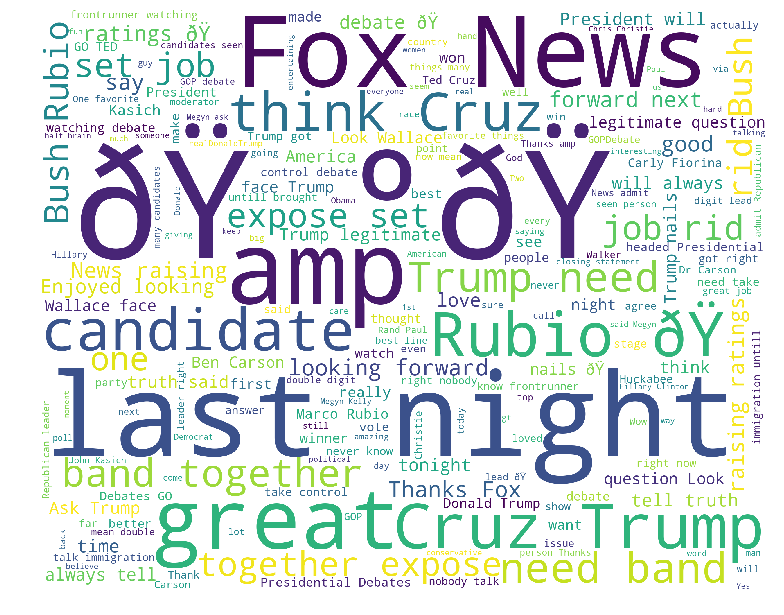

Negative words cloud


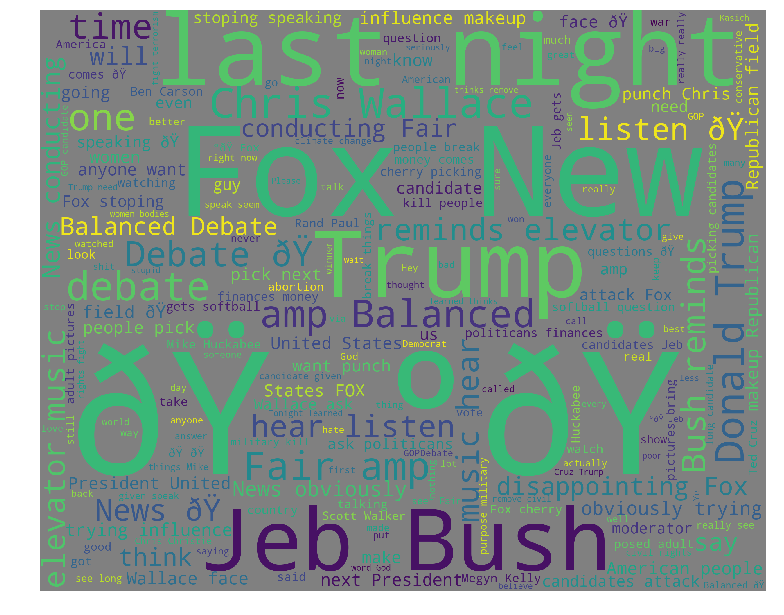

In [10]:
train_pos = train[ train['sentiment']=='Positive']
train_pos = train_pos['text']
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['text']

def draw_wordcloud(data, color = 'black'):
    words=' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                      if 'http' not in word
                          and not word.startswith('@')
                          and not word.startswith('#')
                          and word !='RT'
                      ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                         background_color=color,
                         width=2500,
                         height=2000
                         ).generate(cleaned_word)
    plt.figure(1, figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print('Positive words cloud')
draw_wordcloud(train_pos, 'white')
print('Negative words cloud')
draw_wordcloud(train_neg, 'gray')

In [26]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences 

In [27]:
data = pd.read_csv('d:/machine learning/Tweets.csv')
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head() 

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,568094581041934336,negative,0.6694,Flight Booking Problems,0.3779,Southwest,NaN,BryanAndaya,NaN,0,@SouthwestAir tried to enter that rapid reward...,"[0.0, 0.0]",2015-02-18 09:07:57 -0800,"Houston, Texas",Mountain Time (US & Canada)
1,570302060035497984,negative,1.0000,Bad Flight,0.3447,American,NaN,PBSamson,NaN,0,@AmericanAir thx for responding. I cant watch ...,NaN,2015-02-24 11:19:41 -0800,"Los Angeles, CA",Pacific Time (US & Canada)
2,568190725319311360,negative,0.6534,Late Flight,0.6534,United,NaN,jasemccarty,NaN,0,@united gotta love giving up 1st class upgrade...,NaN,2015-02-18 15:30:00 -0800,BTR/DCA/IAD/MSY - etc,Central Time (US & Canada)
3,568547007003955200,positive,1.0000,NaN,NaN,United,NaN,hartgarfunkel,NaN,0,@united DM sent. Thanks so much for the strong...,NaN,2015-02-19 15:05:44 -0800,"iPhone: 40.732048,-73.994102",Pacific Time (US & Canada)
4,568047650945298432,negative,0.6421,Late Flight,0.3368,United,NaN,OwlyJulie,NaN,0,@united we are never going to get to out gate ...,NaN,2015-02-18 06:01:28 -0800,"Ottawa, Canada",Eastern Time (US & Canada)


In [28]:
data = data[['airline_sentiment', 'text']]
data.head() 

,airline_sentiment,text
0,negative,@SouthwestAir tried to enter that rapid reward...
1,negative,@AmericanAir thx for responding. I cant watch ...
2,negative,@united gotta love giving up 1st class upgrade...
3,positive,@united DM sent. Thanks so much for the strong...
4,negative,@united we are never going to get to out gate ...


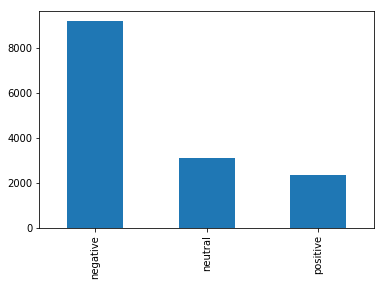

In [29]:
data['airline_sentiment'].value_counts().sort_index().plot.bar() 

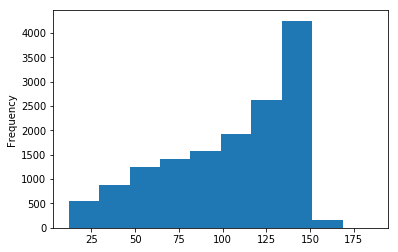

In [30]:
data['text'].str.len().plot.hist() 

In [31]:
data['text'].apply(lambda x: x.lower())
#transform text to lowercase
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
data['text'].head() 

0    SouthwestAir tried to enter that rapid rewards...
1    AmericanAir thx for responding I cant watch 2 ...
2    united gotta love giving up 1st class upgrade ...
3    united DM sent Thanks so much for the strong c...
4    united we are never going to get to out gate a...
Name: text, dtype: object

In [32]:
tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(data['text'].values)

X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5] 

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   16,  267,    1, 1313,   26, 1789, 1429, 1600,  501,    9,
        2459,   31,   67,   11, 3670,  955,   51, 1054, 3671,  139,   20],
       [   0,    0,    0,    0,    0,    0,    0,    0,   13,  328,    7,
         885,    3,   70,  928,   60,  291,   18,   29, 2723, 1790,   20,
        2225,   15,   10,   52,  139, 4604, 4605,   18,   47,  702,  565],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    5, 1371,
         156,  795,   51,  349,  292,  340,  355,    8,   77,    1,   30,
         143,    8,  279,   77,   41,    1, 2724,    3,  125,   11,  256],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           5,  157,  205,   36,   44,  175,    7,    2, 2725,   50,   42],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   

In [33]:
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

In [34]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 33, 256)           1280000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 33, 256)           525312    
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [35]:
y = pd.get_dummies(data['airline_sentiment']).values
[print(data['airline_sentiment'][i], y[i]) for i in range(0,5)] 

negative [1 0 0]
negative [1 0 0]
negative [1 0 0]
positive [0 0 1]
negative [1 0 0]


[None, None, None, None, None]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

In [37]:
batch_size = 32
epochs = 8
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2) 

Epoch 1/8
 - 45s - loss: 0.6581 - acc: 0.7298
Epoch 2/8
 - 48s - loss: 0.4411 - acc: 0.8330
Epoch 3/8
 - 48s - loss: 0.3542 - acc: 0.8661
Epoch 4/8
 - 48s - loss: 0.2948 - acc: 0.8888
Epoch 5/8
 - 49s - loss: 0.2428 - acc: 0.9117
Epoch 6/8
 - 53s - loss: 0.2075 - acc: 0.9215
Epoch 7/8
 - 49s - loss: 0.1706 - acc: 0.9377
Epoch 8/8
 - 50s - loss: 0.1458 - acc: 0.9459


In [38]:
model.save('sentiment_analysis.h5')

In [39]:
predictions = model.predict(X_test)
[print(data['text'][i], predictions[i], y_test[i]) for i in range(0, 5)] 

SouthwestAir tried to enter that rapid rewards contest link on facebook but all my browsers kept popping up security warnings 4 it [9.99999642e-01 1.09583056e-07 2.25901715e-07] [1 0 0]
AmericanAir thx for responding I cant watch 2 mins of this film wout it cutting in and out 4 prolonged prds of time beyond frustrating [9.999049e-01 7.319856e-05 2.196143e-05] [1 0 0]
united gotta love giving up 1st class upgrade bc flight delayed to get another flight also delayed just to ensure I make my connection [0.14864327 0.84979385 0.00156295] [0 1 0]
united DM sent Thanks so much for the strong customer service [9.9996316e-01 3.0366840e-05 6.4562987e-06] [1 0 0]
united we are never going to get to out gate at this rate [9.9901283e-01 5.9408543e-04 3.9317875e-04] [1 0 0]


[None, None, None, None, None]

In [48]:
pos_count, neu_count, neg_count = 0, 0, 0
real_pos, real_neu, real_neg = 0, 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==2:
        pos_count += 1
    elif np.argmax(prediction)==1:
        neu_count += 1
    else:
        neg_count += 1

        if np.argmax(y_test[i])==2:
            real_pos += 1
        elif np.argmax(y_test[i])==1:
            real_neu += 1
        else:
            real_neg +=1

print('Positive predictions:', pos_count)
print('Neutral predictions:', neu_count)
print('Negative predictions:', neg_count)
print('Real positive:', real_pos)
print('Real neutral:', real_neu)
print('Real negative:', real_neg) 

Positive predictions: 462
Neutral predictions: 513
Negative predictions: 1953
Real positive: 100
Real neutral: 231
Real negative: 1622
